In [1]:
import os, sys; sys.path.append("/home/choij/workspace/ChargedHiggsAnalysis/libPython")
import ROOT
from math import pow, sqrt
from Plotter import ComparisonCanvas

Welcome to JupyROOT 6.28/04


In [74]:
ERA = "2017"
HLTPATH = "MeasFakeEl8"
ID = "tight"

WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysis"

trigpathDict = {
    "MeasFakeMu8": "HLT_Mu8_TrkIsoVVL_v",
    "MeasFakeMu17": "HLT_Mu17_TrkIsoVVL_v",
    "MeasFakeEl8": "HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30_v",
    "MeasFakeEl12": "HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30_v",
    "MeasFakeEl23": "HLT_Ele23_CaloIdL_TrackIdL_IsoVL_PFJet30_v"
}

In [85]:
## sample lists
DataStream = ""
if "El" in HLTPATH:
    if "2016" in ERA:  DataStream = "DoubleEG"
    if "2017" in ERA:  DataStream = "SingleElectron"
    if "2018" in ERA:  DataStream = "EGamma"
if "Mu" in HLTPATH:
    DataStream = "DoubleMuon"
    
W  = ["WJets_MG"]
DY = ["DYJets", "DYJets10to50_MG"]
TT = ["TTLL_powheg", "TTLJ_powheg"]
VV = ["WW_pythia", "WZ_pythia", "ZZ_pythia"]
ST = ["SingleTop_sch_Lep", "SingleTop_tch_top_Incl", "SingleTop_tch_antitop_Incl",
      "SingleTop_tW_top_NoFullyHad", "SingleTop_tW_antitop_NoFullyHad"]
MCList = W + DY + TT + VV + ST

In [86]:
## systematics
SYSTs = []
if "El" in HLTPATH:
    SYSTs.append(("PileupReweight"))
    SYSTs.append(("L1PrefireUp", "L1PrefireDown"))
    SYSTs.append(("ElectronRecoSFUp", "ElectronRecoSFDown"))
    SYSTs.append(("JetResUp", "JetResDown"))
    SYSTs.append(("JetEnUp", "JetEnDown"))
    SYSTs.append(("ElectronResUp", "ElectronResDown"))
    SYSTs.append(("ElectronEnUp", "ElectronEnDown"))
    SYSTs.append(("MuonEnUp", "MuonEnDown"))
if "Mu" in HLTPATH:
    SYSTs.append(("PileupReweight"))
    SYSTs.append(("L1PrefireUp", "L1PrefireDown"))
    SYSTs.append(("MuonRecoSFUp", "MuonRecoSFDown"))
    SYSTs.append(("JetResUp", "JetResDown"))
    SYSTs.append(("JetEnUp", "JetEnDown"))
    SYSTs.append(("ElectronResUp", "ElectronResDown"))
    SYSTs.append(("ElectronEnUp", "ElectronEnDown"))
    SYSTs.append(("MuonEnUp", "MuonEnDown"))

In [87]:
## get histograms
HISTs = {}
COLORs = {}

file_path = f"{WORKDIR}/data/MeasFakeRateV4/{ERA}/{HLTPATH}__RunSyst__/DATA/MeasFakeRateV4_{DataStream}.root"
assert os.path.exists(file_path)
f = ROOT.TFile.Open(file_path)
data = f.Get(f"ZEnriched/{ID}/Central/pair/mass"); data.SetDirectory(0)
f.Close()

for sample in MCList:
    file_path = f"{WORKDIR}/data/MeasFakeRateV4/{ERA}/{HLTPATH}__RunSyst__/MeasFakeRateV4_{sample}.root"
    assert os.path.exists(file_path)
    # get central histogram
    try:
        f = ROOT.TFile.Open(file_path)
        h = f.Get(f"ZEnriched/{ID}/Central/pair/mass");   h.SetDirectory(0)
        # get systematic histograms
        hSysts = []
        for systset in SYSTs:
            if len(systset) == 2:
                systUp, systDown = systset
                h_up = f.Get(f"ZEnriched/{ID}/{systUp}/pair/mass"); h_up.SetDirectory(0)
                h_down = f.Get(f"ZEnriched/{ID}/{systDown}/pair/mass"); h_down.SetDirectory(0) 
                hSysts.append((h_up, h_down))
            else:
                # only one systematic source
                syst = systset
                h_syst = f.Get(f"ZEnriched/{ID}/{syst}/pair/mass"); h_syst.SetDirectory(0)
                hSysts.append((h_syst))
        f.Close()
    except:
        print(sample)
        continue
    
    # estimate total unc. bin by bin
    for bin in range(h.GetNcells()):
        stat_unc = h.GetBinError(bin)
        envelops = []
        for hset in hSysts:
            if len(hset) == 2:
                h_up, h_down = hset
                systUp = abs(h_up.GetBinContent(bin) - h.GetBinContent(bin))
                systDown = abs(h_up.GetBinContent(bin) - h.GetBinContent(bin))
                envelops.append(max(systUp, systDown))
            else:
                h_syst = hset
                syst = abs(h_syst.GetBinContent(bin) - h.GetBinContent(bin))
                envelops.append(syst)

            total_unc = pow(stat_unc, 2)
            for unc in envelops:
                total_unc += pow(unc, 2)
            total_unc = sqrt(total_unc)
            h.SetBinError(bin, total_unc)
    HISTs[sample] = h.Clone(sample)

# now scale MC histograms
rate_data = data.Integral()
rate_mc = 0.
for sample in MCList:
    rate_mc += HISTs[sample].Integral()
print(f"MC histograms scaled to {rate_data/rate_mc}")
for hist in HISTs.values(): hist.Scale(rate_data/rate_mc)

MC histograms scaled to 0.000128312657397313


In [88]:
#### merge backgrounds
def add_hist(name, hist, histDict):
    # content of dictionary should be initialized as "None"
    if histDict[name] is None:
        histDict[name] = hist.Clone(name)
    else:
        histDict[name].Add(hist)
        
temp_dict = {}
temp_dict["W"]  = None
temp_dict["DY"] = None
temp_dict["TT"] = None
temp_dict["VV"] = None 
temp_dict["ST"] = None

for sample in W:
    if not sample in HISTs.keys(): continue
    add_hist("W", HISTs[sample], temp_dict)
for sample in DY:
    if not sample in HISTs.keys(): continue
    add_hist("DY", HISTs[sample], temp_dict)
for sample in TT:
    if not sample in HISTs.keys(): continue
    add_hist("TT", HISTs[sample], temp_dict)
for sample in VV:
    if not sample in HISTs.keys(): continue
    add_hist("VV", HISTs[sample], temp_dict)
for sample in ST:
    if not sample in HISTs.keys(): continue
    add_hist("ST", HISTs[sample], temp_dict)

#### remove none histograms
BKGs = {}
for key, value in temp_dict.items():
    if value is None: continue
    BKGs[key] = value

In [89]:
COLORs["data"] = ROOT.kBlack
COLORs["W"]  = ROOT.kMagenta
COLORs["DY"] = ROOT.kGray
COLORs["TT"] = ROOT.kViolet
COLORs["VV"] = ROOT.kGreen
COLORs["ST"] = ROOT.kAzure

In [102]:
xTitle = ""
if "Mu" in HLTPATH:
    xTitle = "M(#mu^{+}#mu^{-})"
    xRange = [75., 108.]
if "El" in HLTPATH:
    xTitle = "M(e^{+}e^{-})"
    xRange = [55., 125.]

config = {"era": ERA,
          "xTitle": xTitle,
          "yTitle": "Events / GeV",
          "xRange": xRange,}

textInfo = {
    "CMS": [0.04, 61, [0.12, 0.91]],
    "Work in progress": [0.035, 52, [0.21, 0.91]],
    "Prescaled (13 TeV)": [0.035, 42, [0.665, 0.91]],
    trigpathDict[HLTPATH]: [0.035, 42, [0.17, 0.83]],
    f"{ERA} / {ID.upper()} ID": [0.035, 42, [0.17, 0.77]]
}

In [103]:
c = ComparisonCanvas(config=config)
c.drawBackgrounds(BKGs, COLORs)
c.drawData(data)
c.drawRatio()
c.drawLegend()
c.finalize(textInfo=textInfo)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


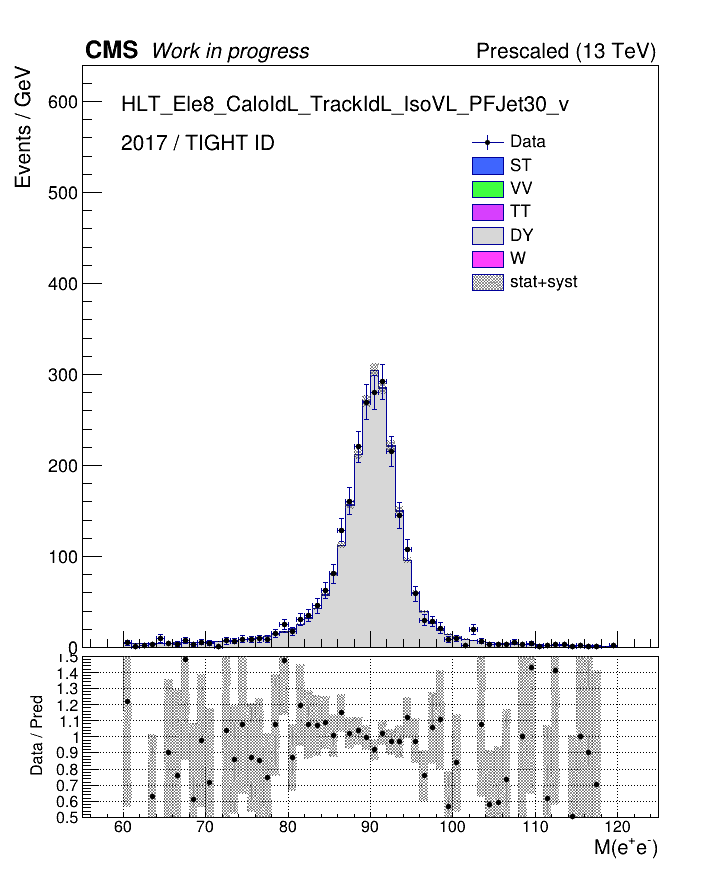

In [104]:
c.draw()